In [1]:
import numpy as np
import xarray as xr
from gsw.conversions import CT_from_pt
from gsw.density import sigma2
import matplotlib.pyplot as plt

In [2]:
data_path = "/mnt/g/My Drive/GTC/ecco_data_full"
sections = ["26N", "30S", "55S", "60S", "southern_ocean"]
coordinates = ["latitude", "longitude", "Z", "time"]

In [3]:
section = "60S"
use_bolus = True
use_density = True

In [4]:
assert section in sections
vm = xr.open_mfdataset(f"{data_path}/{section}/ECCO_L4_OCEAN_VEL_05DEG_MONTHLY_V4R4/*.nc",
                       coords="minimal",
                       data_vars="minimal",
                       parallel=True, compat="override")
vm = vm[["NVEL"]].transpose(*coordinates).isel(Z=slice(None, None, -1)).fillna(0.)
vm = vm.rename({"NVEL": "vm"})
if use_bolus:
    ve = xr.open_mfdataset(f"{data_path}/{section}/ECCO_L4_BOLUS_05DEG_MONTHLY_V4R4/*.nc",
                        coords="minimal",
                        data_vars="minimal",
                        parallel=True, compat="override")
    ve = ve[["NVELSTAR"]].transpose(*coordinates).isel(Z=slice(None, None, -1)).fillna(0.)
    ve = ve.rename({"NVELSTAR": "ve"})
if use_density:
    density = xr.open_mfdataset(f"{data_path}/{section}/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/*.nc",
                                coords="minimal",
                                data_vars="minimal",
                                parallel=True, compat="override")
    density = density[["THETA", "SALT"]].transpose(*coordinates).isel(Z=slice(None, None, -1))
    ct = CT_from_pt(SA=density["SALT"], pt=density["THETA"])
    s2 = sigma2(SA=density["SALT"], CT=ct).to_dataset()
    s2 = s2.rename({list(s2.data_vars)[0]: "sigma_2"})

In [5]:
v = vm["vm"] + ve["ve"] if use_bolus else vm["vm"]

In [6]:
v_np = v.to_numpy()
s2_np = s2["sigma_2"].to_numpy()

temp = s2_np.flatten()
temp = temp[~np.isnan(temp)]
l, u = np.quantile(temp, [0.5, 0.99])
s2_range = np.linspace(min(temp), max(temp), 20)
s2_range

array([35.23435695, 35.33264173, 35.43092652, 35.5292113 , 35.62749609,
       35.72578088, 35.82406566, 35.92235045, 36.02063523, 36.11892002,
       36.2172048 , 36.31548959, 36.41377437, 36.51205916, 36.61034395,
       36.70862873, 36.80691352, 36.9051983 , 37.00348309, 37.10176787])

In [7]:
depth_precision = 500

Z = v["Z"].to_numpy()
Z_interp = np.linspace(min(Z), max(Z), depth_precision)
n_lats, n_lons, n_depths, n_times = s2_np.shape
s2_interp = np.empty((n_lats, n_lons, depth_precision, n_times))
for lat in range(n_lats):
    for lon in range(n_lons):
        for t in range(n_times):
            s2_interp[lat, lon, :, t] = np.interp(x=Z_interp, xp=Z, fp=s2_np[lat, lon, :, t])

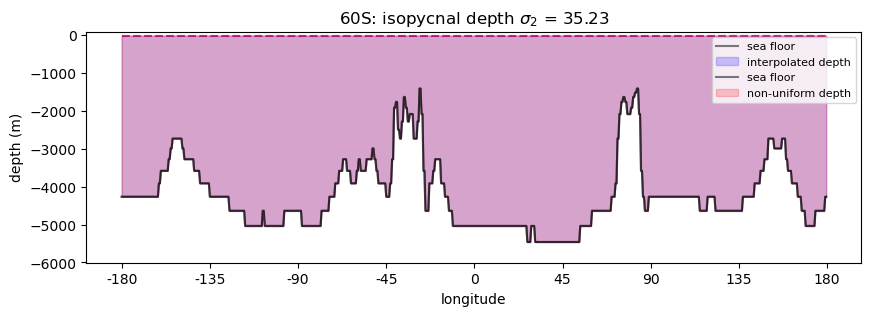

In [18]:
for d in s2_range:
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_xlabel("longitude"); ax.set_ylabel("depth (m)")
    ax.set_title(f"{section}: isopycnal depth $\\sigma_2$ = {round(d, 2)}")
    ax.set_ylim(min(Z)-100, max(Z)+100)
    ax.set_xticks(np.arange(0, 721, 90), np.arange(-180, 181, 45))

    # water column is all lighter than d
    nan_iso = np.where(s2_interp[1, :, 0, -1] <= d)[0]
    # water column is all nan values
    nan_lons = np.where(np.isnan(s2_interp[1, :, :, -1]).all(axis=1))[0]
    # indices of isopycnals
    isopycnals = np.argmax(s2_interp[1, :, :, -1] <= d, axis=1)
    # fill in full water columns
    isopycnals[isopycnals == 0] = -1
    # get depth values
    isopycnals = Z_interp[isopycnals]
    # fill in nan values and full columns
    isopycnals[nan_iso] = np.nan
    isopycnals[nan_lons] = np.nan
    # find sea floor
    bottom = Z_interp[np.sum(np.isnan(s2_interp[1, :, :, -1]), axis=1)]
    bottom[nan_lons] = np.nan
    ax.plot(bottom, linestyle="-", color="black", alpha=0.5, label="sea floor")
    # account for sea floor in plot
    isopycnals[isopycnals <= bottom] = np.nan
    ax.plot(isopycnals, linestyle="--", color="blue", alpha=0.5)
    ax.fill_between(np.arange(0, 720), isopycnals, bottom, color="blue", alpha=0.2, label="interpolated depth")

    nan_iso = np.where(s2_np[1, :, 0, -1] <= d)[0]
    nan_lons = np.where(np.isnan(s2_np[1, :, :, -1]).all(axis=1))[0]
    isopycnals = np.argmax(s2_np[1, :, :, -1] <= d, axis=1)
    isopycnals[isopycnals == 0] = -1
    isopycnals = Z[isopycnals]
    isopycnals[nan_iso] = np.nan
    isopycnals[nan_lons] = np.nan
    bottom = Z[np.sum(np.isnan(s2_np[1, :, :, -1]), axis=1)]
    bottom[nan_lons] = np.nan
    ax.plot(bottom, linestyle="-", color="black", alpha=0.5, label="sea floor")
    isopycnals[isopycnals <= bottom] = np.nan
    ax.plot(isopycnals, linestyle="--", color="red", alpha=0.5)
    ax.fill_between(np.arange(0, 720), isopycnals, bottom, color="red", alpha=0.2, label="non-uniform depth")

    ax.legend(loc=0, prop={"size": 8})
    # plt.show()
    # break
    plt.tight_layout()
    plt.savefig(f"/mnt/g/My Drive/GTC/EDA/isopycnals/{round(d, 2)}.png", dpi=400)
    plt.close()